<a href="https://colab.research.google.com/github/glorivaas/Machine_Learning25/blob/main/Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9 - Multi Layer Perceptron, HOMEWORK

### Author: Gloria Rivas

# Presentation on Tensors and Linear Layers
--------------------

We shall start off by going through a [short presentation on tensors and linear layers](https://github.com/SzymonNowakowski/Machine-Learning-2024/blob/master/tensors_and_linear_layers.pdf). It is best to first download it and then go through it in a slide-show layout.

# Broadcasting
-------------------------------

Broadcasting is a powerful feature in PyTorch that allows operations on tensors of different shapes by automatically expanding their dimensions to match each other where possible. This mechanism is essential for performing element-wise operations without needing to manually reshape or replicate data.

In broadcasting, PyTorch compares the shapes of the tensors element-wise from the right. If the dimensions are equal or one of them is 1, the operation can proceed. The smaller tensor is virtually expanded (without copying data) to match the larger tensor's shape.





## Example in PyTorch


In [2]:

import torch

A = torch.tensor([[1.], [2.], [3.]])  # Shape: (3, 1)
B = torch.tensor([10., 20., 30.])     # Shape: (3) - treated as (1, 3)

C = A * B  # Shape: (3, 3) via broadcasting
print(C)


tensor([[10., 20., 30.],
        [20., 40., 60.],
        [30., 60., 90.]])


## Note on Numpy
The same broadcasting mechanism exists in NumPy, as PyTorch's behavior was designed to be compatible with it:




In [3]:
import numpy as np

A = np.array([[1.], [2.], [3.]])  # Shape: (3, 1)
B = np.array([10., 20., 30.])     # Shape: (3)

C = A * B  # Also produces shape (3, 3)
print(C)

[[10. 20. 30.]
 [20. 40. 60.]
 [30. 60. 90.]]


## Note on Previous Class Code

We also encountered broadcasting in our previous class session:



In [4]:
N = 100
focus1 = torch.tensor([-2.0, 0.0])             # First focus,                        sized (2)
points = torch.rand((N, 2)) * 10 - 5           # Uniformly distributed in [-5, 5]    sized (N, 2)

############### when we computed distances to focal points ##############################
dist1 = torch.norm(points - focus1, dim=1)     # the focus 1 gets expanded to (1, 2) then broadcasted to (N, 2)
                                               # to match the points tensor

                                               # effectively what happens is that
                                               # the focus point gets substracted from every other point

                                               # also: note how natural this notation feels here

############### when we computed pairwise point-to-point distances #####################
# Compute all pairwise distances in parallel
print(points.unsqueeze(1).size())                   # sized: (N, 1, 2)
print(points.unsqueeze(0).size())                   # sized: (1, N, 2)

diffs = points.unsqueeze(1) - points.unsqueeze(0)   # sized: (N, N, 2) because of broadcasting
distances = torch.norm(diffs, dim=-1)               # sized: (N, N)

print(distances.size())                             # N x N


torch.Size([100, 1, 2])
torch.Size([1, 100, 2])
torch.Size([100, 100])


# Multi Layer Perceptron (MLP) Diagram
------------------

![network diagram](https://raw.githubusercontent.com/SzymonNowakowski/Machine-Learning-2024/refs/heads/master/MLP_diagram.jpg)

# Task
-------------------

A nonlinear component in-between the linear layers is essential. Why?

# A Non-Linearity
---------------------

$$
l_{i+1} = f(W \cdot l_i),
$$
with $f$ being a sigmoid $f(\cdot)=\sigma(\cdot)$, hiperbolic tangent $f(\cdot)=\tanh(\cdot)$ or a Rectified Linear Unit (ReLU) $f(\cdot)=[\cdot]_+$ (taking the positive part).

The **sigmoid function** is defined as:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

It maps any input $x$ to the range $(0,1)$, making it useful for probabilistic interpretations and smooth gradient updates. However, it can suffer from vanishing gradients for large positive or negative inputs.

The **hyperbolic tangent (tanh) function** is defined as:

$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

It maps any input $x$ to the range $(-1,1)$, making it **zero-centered**, which can help with optimization compared to the sigmoid function.

Alternatively, **tanh** can be expressed as a **scaled sigmoid**:

$$
\tanh(x) = 2\sigma(2x) - 1
$$

This shows that **tanh** is just a stretched and shifted version of **sigmoid**, allowing for stronger gradients in the middle range and reducing saturation effects compared to sigmoid.


As we said, a non-linear component is essential:
1. without it, a compostion of linear components would be just a linear component, so a multilayer network would be equivalent to a single layered network.
2. it is a nonlinear component that enables a neural network to express nonlinear functions, too.




# MNIST dataset
----------------------

In this workshop, we will construct an MLP network designed to a specific task of classification of MNIST dataset: a set of handwritten digits from *zero* to *nine*. MNIST stands for Modified National Institute of Standards and Technology database.

**You can read more about this dataset [here](https://colah.github.io/posts/2014-10-Visualizing-MNIST/#MNIST).**




# Multi Layer Perceptron Notation
---------------------------------

In this workshop we will be classifying 28 by 28 images into 10 classes. Thus, a four layer perceptron (our classificator) we will work further with can be defined as
$\hat f:\mathbb{R}^{28\cdot 28} \rightarrow \mathbb{R}^{10}$ defined as

$$\hat f \left(x; W_1, W_2, W_3, W_4, b_1, b_2, b_3, b_4 \right) =  W_4 \left[ W_3 \left[ W_2 \left[ W_1 x  + b_1 \right]_+  + b_2 \right]_+  + b_3 \right]_+ + b_4,$$

where matrices $W_1, \ldots, W_4$ are tensors of order two (matrices) with matching dimensions and bias terms $b_1, \ldots, b_4$ are tensors of order one (vectors) of matching dimensions, and we are using ReLU activation.

Note, that there is no nonlinear activation after the last layer in our neural network. **There is an implicit softmax applied while cross entropy loss is calculated by `torch.nn.functional`.**


# Reading MNIST Dataset to Play with It
--------------------

In [5]:
import torch
import torchvision
from matplotlib import pyplot

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.27MB/s]


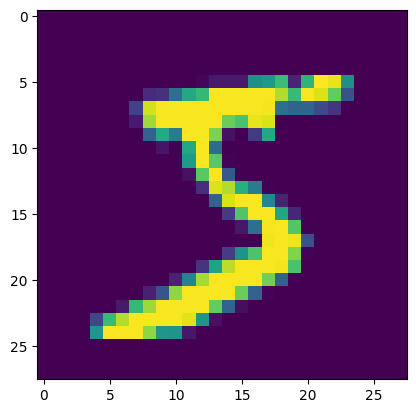

In [ ]:
train_image, train_target = trainset[0]    #let us examine the 0-th sample
pyplot.imshow(train_image)
pyplot.show()

In [6]:
trainset.data[0]     #it will be shown in two rows, so a human has hard time classificating it

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [7]:
trainset[0][1]    #check if you classified it correctly in your mind

5

# Rereading the MNIST Data (Serious Preparation for Training)
------------------

In [ ]:
(trainset.data.numpy().mean()/255.0, trainset.data.numpy().std()/255.0)   #MNIST datapoints are RGB integers 0-255

(np.float64(0.1306604762738429), np.float64(0.30810780385646264))

# Task
---------------

Why do we need to normalize the data, and not feed the NN with the 0-255 integers?

In [8]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

## Visualizing Data


### Labels (Ground Truth Outputs)

In [9]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i<5:
            print(i, "-th batch labels :", batch_labels)

0 -th batch labels : tensor([4, 8, 1,  ..., 8, 4, 0])
1 -th batch labels : tensor([7, 5, 8,  ..., 4, 0, 9])
2 -th batch labels : tensor([3, 6, 2,  ..., 7, 7, 1])
3 -th batch labels : tensor([5, 8, 9,  ..., 7, 2, 9])
4 -th batch labels : tensor([1, 6, 0,  ..., 4, 8, 3])


A single label is an entity of order zero (a constant), but batched labels are of order one. The first (and only) index is a sample index within a batch.

### Inputs

In [10]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i==0:
            print(i, "-th batch inputs :", batch_inputs)

0 -th batch inputs : tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
     

OK, so each data image was initially a two dimensional image when we first saw it, but now the batches have order 4. The first index is a sample index within a batch, but a second index is always 0. This index represents a Channel number inserted here by `ToTensor()` transformation, always 0. As this order is one-dimensional, we can get rid of it, later, in training, in `Flatten` layer or by using `squeeze()` on a tensor.

# MLP Definition
-----------------

Your job now is to take the (fully functional) definition of the MLP structure and get rid off the Sequential layer.


In [11]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1 * 28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 256)
        self.fc4 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.dropout(x)
        return x

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1 * 28 * 28, 1024)
        self.linear2 = nn.Linear(1024, 2048)
        self.linear3 = nn.Linear(2048, 256)
        self.linear4 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):      # B, 1, 28, 28
        x = self.flatten(x)    # -> (B, 784)
        x = self.relu(self.linear1(x))  # -> (B, 1024)
        x = self.relu(self.linear2(x))  # -> (B, 2048)
        x = self.relu(self.linear3(x))  # -> (B, 256)
        x = self.linear4(x)             # -> (B, 10)
        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [13]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.305328369140625
epoch: 0 batch: 1 current batch loss: 2.0893919467926025
epoch: 0 batch: 2 current batch loss: 1.6497840881347656
epoch: 0 batch: 3 current batch loss: 1.178908348083496
epoch: 0 batch: 4 current batch loss: 0.9820543527603149
epoch: 0 batch: 5 current batch loss: 1.3001515865325928
epoch: 0 batch: 6 current batch loss: 1.167169451713562
epoch: 0 batch: 7 current batch loss: 0.9358197450637817
epoch: 0 batch: 8 current batch loss: 0.8163487315177917
epoch: 0 batch: 9 current batch loss: 0.6237096786499023
epoch: 0 batch: 10 current batch loss: 0.6126407384872437
epoch: 0 batch: 11 current batch loss: 0.6901042461395264
epoch: 0 batch: 12 current batch loss: 0.6145676970481873
epoch: 0 batch: 13 current batch loss: 0.5711794495582581
epoch: 0 batch: 14 current batch loss: 0.5085729360580444
epoch: 0 batch: 15 current batch loss: 0.49884769320487976
epoch: 0 batch: 16 current batch loss: 0.48151612281799316
epoch: 0 

# Testing
----------------------

Correct the code below so it works.

In [14]:
good = 0
wrong = 0

net.eval()
with torch.no_grad():
    for batch, data in enumerate(testloader):
        datapoint, label = data  # datapoint: (B, 1, 28, 28), label: (B,)
        datapoint = datapoint.to(device)
        label = label.to(device)

        prediction = net(datapoint)  # shape: (B, 10)
        predicted_class = torch.argmax(prediction, dim=1)  # shape: (B,)

        good += (predicted_class == label).sum().item()
        wrong += (predicted_class != label).sum().item()

accuracy = good / (good + wrong)
print("Accuracy =", accuracy)

Accuracy = 0.9808


# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




Step 000 | Loss: 4.9859 | Avg Confidence: 0.0518
Stopped early at step 5 — all digits confidently recognized.


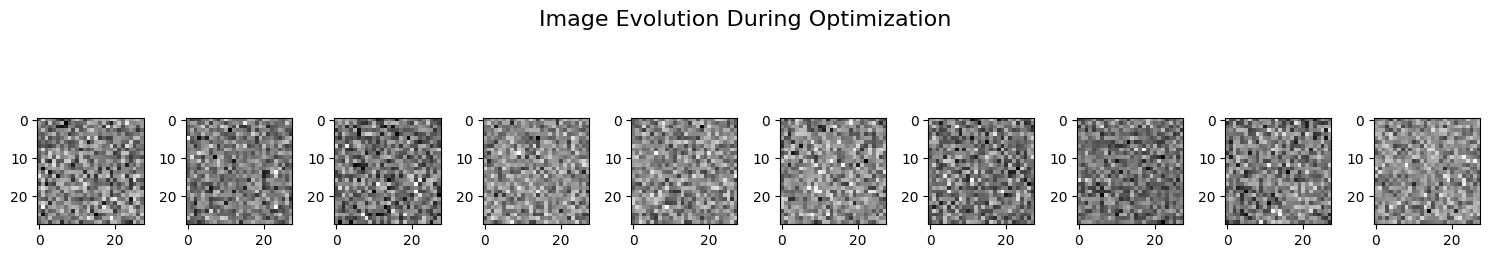

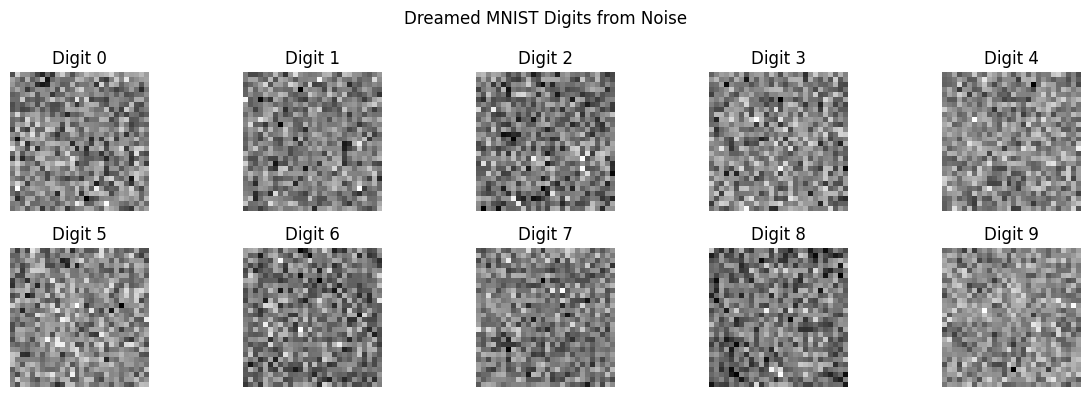

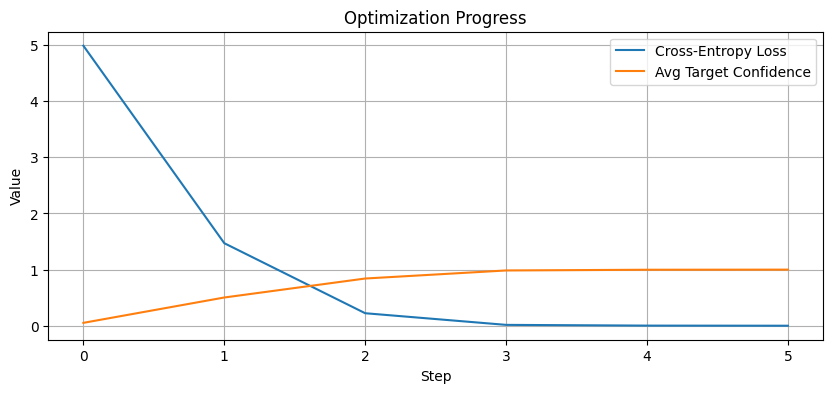

In [39]:
#Part 1
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

dream_images = torch.randn(10, 1, 28, 28, device=device, requires_grad=True)
target_labels = torch.arange(10, device=device)

net.eval()
optimizer = torch.optim.Adam([dream_images], lr=0.1)

loss_history = []
confidence_history = []
snapshots = []

for step in range(300):
    optimizer.zero_grad()

    logits = net(dream_images)
    loss = F.cross_entropy(logits, target_labels)

    probs = F.softmax(logits, dim=1)
    correct_conf = probs[torch.arange(10), target_labels].detach().cpu()

    loss_history.append(loss.item())
    confidence_history.append(correct_conf.mean().item())

    loss.backward()
    optimizer.step()

    if step % 50 == 0 or step == 299:
        snapshots.append(dream_images.detach().cpu().clone())
        print(f"Step {step:03d} | Loss: {loss.item():.4f} | Avg Confidence: {correct_conf.mean():.4f}")

    if (correct_conf > 0.99).all():
        print(f"Stopped early at step {step} — all digits confidently recognized.")
        break

fig, axes = plt.subplots(len(snapshots), 10, figsize=(15, 3 * len(snapshots)))
axes = np.atleast_2d(axes)

for row, snap in enumerate(snapshots):
  for col in range(10):
    image = snap[col]
    image = image.squeeze().numpy()
    axes[row, col].imshow(image, cmap='gray')

plt.suptitle("Image Evolution During Optimization", fontsize=16)
plt.tight_layout()
plt.show()

final_images = dream_images.detach().cpu().squeeze()

plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(final_images[i], cmap='gray')
    plt.title(f"Digit {i}")
    plt.axis('off')
plt.suptitle("Dreamed MNIST Digits from Noise")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(loss_history, label="Cross-Entropy Loss")
plt.plot(confidence_history, label="Avg Target Confidence")
plt.xlabel("Step")
plt.ylabel("Value")
plt.title("Optimization Progress")
plt.legend()
plt.grid(True)
plt.show()


#**OBSERVATIONS**
- Initial loss is high (~6.6), which is expected for random noise and cross_entropy loss over 10 classes.

- Average confidence starts low (~0.0981 ≈ 1/10), which is also expected as it is basically random guessing.

- By step 5, the average confidence jumped to > 99% for all digits.

The generated images often do not resemble actual MNIST digits, because the optimization is focused solely on activating the neural network's internal representations, not on generating images that humans would recognize. This highlights the difference between what a network "sees" and what we perceive.

# PART 2 **IDEA**
To generate an image resembling multiple digits, optimize the input toward a soft label distribution using a loss like KL divergence. This guides the model to activate multiple class neurons at once — creating hybrid or ambiguous images that resemble more than one digit. To create an image resembling both "3" and "8", we use a soft target like = [0, 0, 0, 0.5, 0, 0, 0, 0, 0.5, 0] #(50% class 3, 50% class 8).

We start with a single noise image, create a soft target distribution and use KL-distribution instead of cross-entropy.

Step 0, Loss: 3.6420
Step 50, Loss: 0.0074
Step 100, Loss: 0.0014
Step 150, Loss: 0.0007
Step 200, Loss: 0.0005
Step 250, Loss: 0.0003
Step 299, Loss: 0.0003


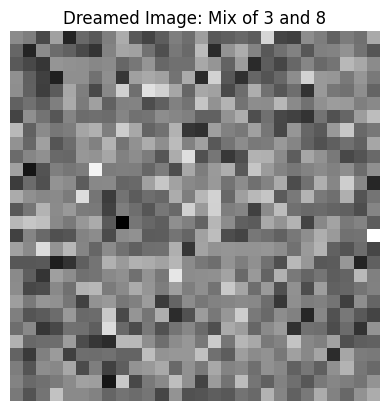

Final class probabilities:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 0.0001
Class 3: 0.4999
Class 4: 0.0000
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.0000
Class 8: 0.4998
Class 9: 0.0001


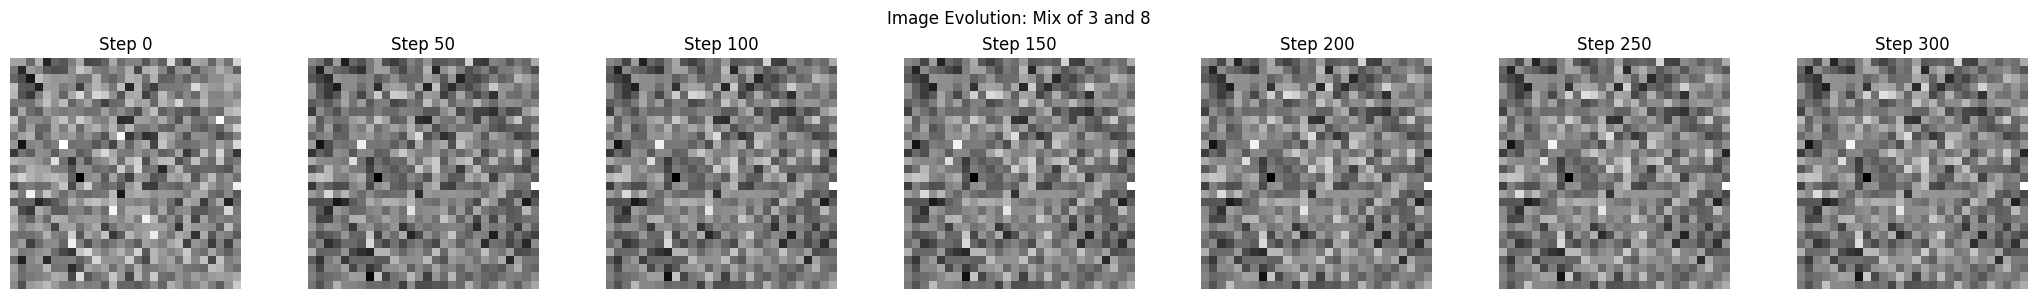

In [26]:
# Part 2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

mixed_image = torch.randn(1, 1, 28, 28, device=device, requires_grad=True)

target_distribution = torch.tensor([[0, 0, 0, 0.5, 0, 0, 0, 0, 0.5, 0]], device=device)

net.eval()
optimizer = torch.optim.Adam([mixed_image], lr=0.1)
snapshots = []

prob_history_3 = []
prob_history_8 = []
steps_recorded = []

for step in range(300):
    optimizer.zero_grad()

    logits = net(mixed_image)
    probs = F.softmax(logits, dim=1).detach().cpu().squeeze()
    log_probs = F.log_softmax(logits, dim=1)
    loss = F.kl_div(log_probs, target_distribution, reduction='batchmean')
    prob_history_3.append(probs[3].item())
    prob_history_8.append(probs[8].item())
    steps_recorded.append(step)

    loss.backward()
    optimizer.step()

    if step % 50 == 0 or step == 299:
        snapshots.append(mixed_image.detach().cpu().clone())
        print(f"Step {step}, Loss: {loss.item():.4f}")

result_img = mixed_image.detach().cpu().squeeze()
plt.imshow(result_img, cmap='gray')
plt.title("Dreamed Image: Mix of 3 and 8")
plt.axis('off')
plt.show()

with torch.no_grad():
    final_probs = F.softmax(net(mixed_image), dim=1).squeeze().cpu()
    print("Final class probabilities:")
    for i, p in enumerate(final_probs):
        print(f"Class {i}: {p:.4f}")

fig, axes = plt.subplots(1, len(snapshots), figsize=(3 * len(snapshots), 3))
axes = np.atleast_1d(axes)

for i, img in enumerate(snapshots):
    axes[i].imshow(img.squeeze().numpy(), cmap='gray')
    axes[i].set_title(f"Step {i * 50}")
    axes[i].axis('off')

plt.suptitle("Image Evolution: Mix of 3 and 8")
plt.tight_layout()
plt.show()


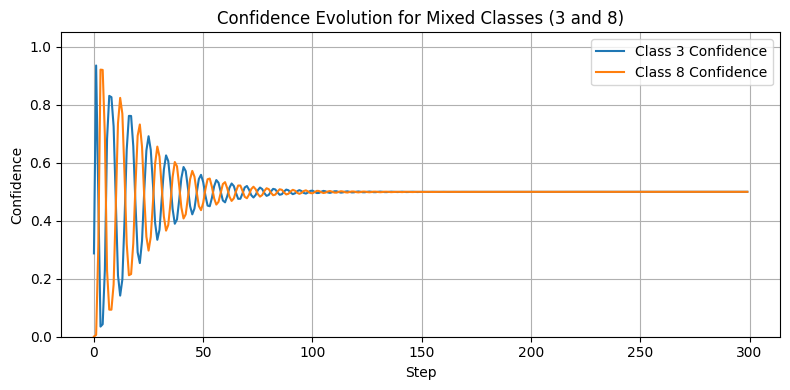

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(steps_recorded, prob_history_3, label="Class 3 Confidence")
plt.plot(steps_recorded, prob_history_8, label="Class 8 Confidence")
plt.xlabel("Step")
plt.ylabel("Confidence")
plt.title("Confidence Evolution for Mixed Classes (3 and 8)")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The oscillations indicate that the optimizer tweaks the image to activate class 3, then overcorrects toward 8, and so on.


=== Training with L2 Penalty: λ = 0.001 ===
λ = 0.001 | Accuracy: 10/10

=== Training with L2 Penalty: λ = 0.01 ===
λ = 0.010 | Accuracy: 10/10

=== Training with L2 Penalty: λ = 0.1 ===
λ = 0.100 | Accuracy: 10/10

=== Training with L2 Penalty: λ = 1.0 ===
λ = 1.000 | Accuracy: 10/10

=== Training with L2 Penalty: λ = 10.0 ===
λ = 10.000 | Accuracy: 10/10


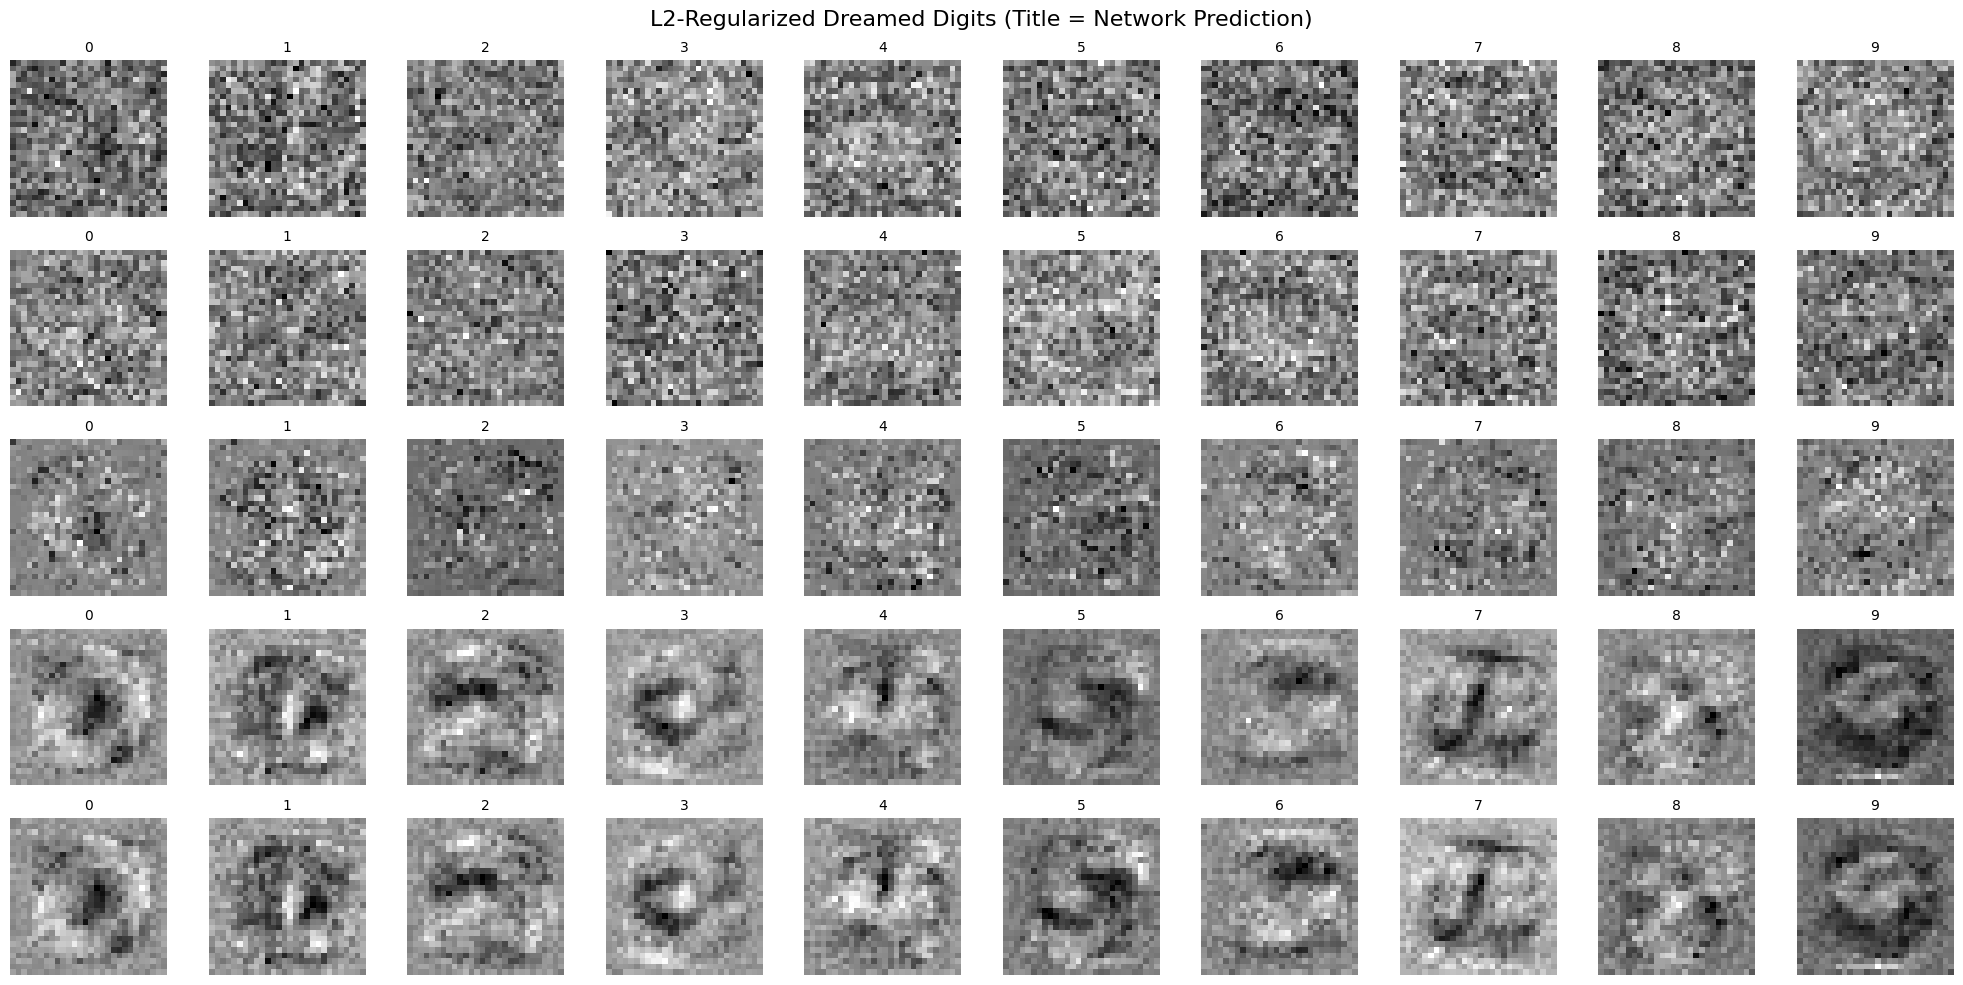

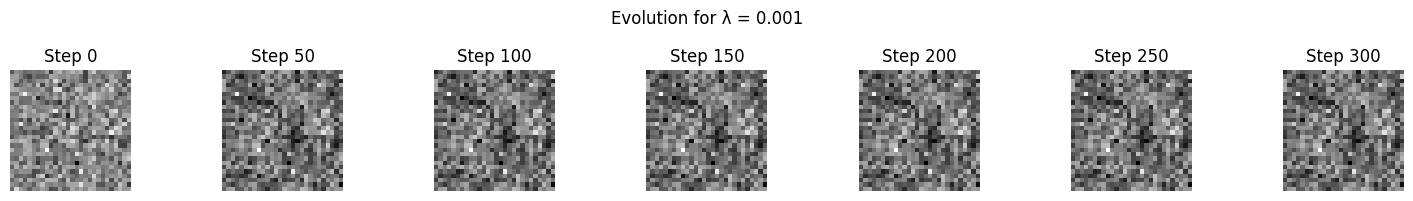

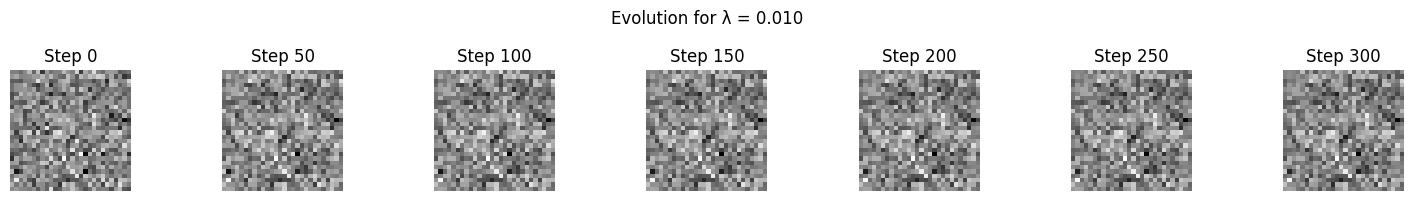

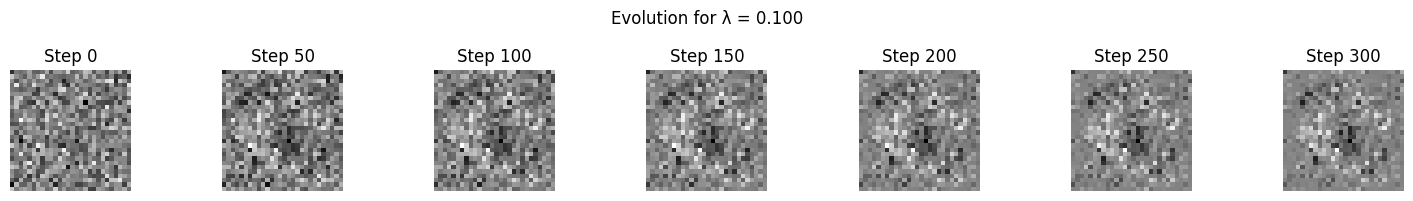

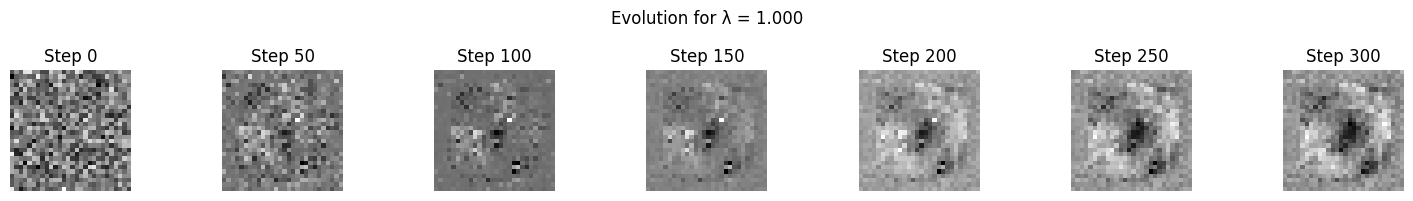

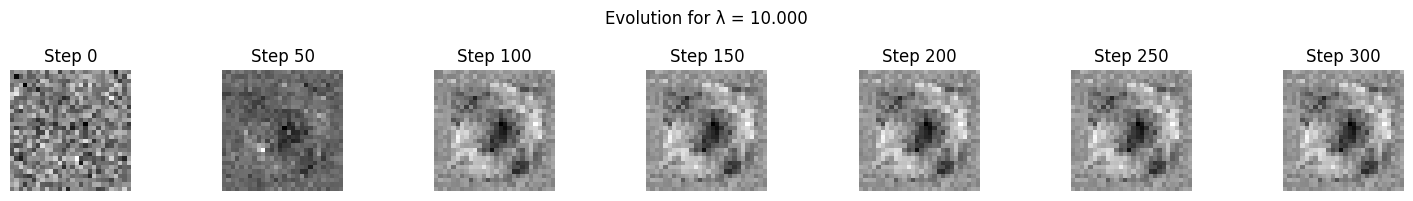

In [38]:
# Part 3
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

target_labels = torch.arange(10, device=device)

lambda_values = [0.001, 0.01, 0.1, 1.0, 10.0]
results = []
snapshots_per_lambda = []


net.eval()

for lambda_l2 in lambda_values:
    print(f"\n=== Training with L2 Penalty: λ = {lambda_l2} ===")

    dreamed_inputs = torch.randn(10, 1, 28, 28, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([dreamed_inputs], lr=0.1)
    image_snapshots = []

    for step in range(300):
        optimizer.zero_grad()
        logits = net(dreamed_inputs)
        loss_ce = F.cross_entropy(logits, target_labels)
        l2_term = dreamed_inputs.pow(2).mean()
        loss = loss_ce + lambda_l2 * l2_term
        loss.backward()
        optimizer.step()

        if step % 50 == 0 or step == 299:
            image_snapshots.append(dreamed_inputs.detach().cpu().clone())

    preds = torch.argmax(logits, dim=1).detach().cpu()
    correct = (preds == target_labels.cpu()).sum().item()
    print(f"λ = {lambda_l2:.3f} | Accuracy: {correct}/10")
    results.append((lambda_l2, dreamed_inputs.detach().cpu(), preds))
    snapshots_per_lambda.append((lambda_l2, image_snapshots))


n_rows = len(lambda_values)
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.0 * n_cols, 2.0 * n_rows))

for row, (lam, images, preds) in enumerate(results):
    for col in range(n_cols):
        ax = axes[row][col] if n_rows > 1 else axes[col]
        ax.imshow(images[col].squeeze(), cmap='gray')
        ax.set_title(f"{preds[col].item()}", fontsize=10)
        ax.axis('off')
        if col == 0:
            ax.set_ylabel(f"λ = {lam:.3f}", fontsize=12)

plt.suptitle("L2-Regularized Dreamed Digits (Title = Network Prediction)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

for lam, snaps in snapshots_per_lambda:
    fig, axes = plt.subplots(1, len(snaps), figsize=(15, 2))
    for i, snap in enumerate(snaps):
        axes[i].imshow(snap[0].squeeze(), cmap='gray')
        axes[i].set_title(f"Step {i*50}")
        axes[i].axis('off')
    plt.suptitle(f"Evolution for λ = {lam:.3f}")
    plt.tight_layout()
    plt.show()


- Low λ (0.001–0.01):

 Images are highly noisy and not human-recognizable.

 The optimizer exploits subtle pixel-level artifacts to trick the network.

- Mid λ (0.1–1.0):

 Noise reduces and digit-like patterns start to appear.

 Balance between visual structure and classification success.

- High λ (10.0):

 Digits are smooth, abstract, and look more realistic.

 L2 regularization forces the optimizer to create minimal but effective representations.

 Even though we could expect accuracy to drop, in this experiment we have that a higher L2 penalty makes the input less noisy, more spatially smooth and lower in intensity, but the optimizer can still adjust subtle features to get correct classifications; wecan think of these as the "essence" of each digit.

In [42]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

snapshots = []

lambda_l2 = 1.0
target_labels = torch.arange(10, device=device)
dreamed_inputs = torch.randn(10, 1, 28, 28, device=device, requires_grad=True)
optimizer = torch.optim.Adam([dreamed_inputs], lr=0.1)

net.eval()

for step in range(300):
    optimizer.zero_grad()
    logits = net(dreamed_inputs)
    loss_ce = F.cross_entropy(logits, target_labels)
    l2_term = dreamed_inputs.pow(2).mean()
    loss = loss_ce + lambda_l2 * l2_term
    loss.backward()
    optimizer.step()

    if step % 50 == 0 or step == 299:
        snapshots.append(dreamed_inputs.detach().cpu().clone())

fig, axes = plt.subplots(1, 10, figsize=(15, 2))

ims = []
for snap in snapshots:
    images = []
    for i in range(10):
        img = snap[i].squeeze().numpy()
        im = axes[i].imshow(img, cmap='gray', animated=True)
        axes[i].axis('off')
        images.append(im)
    ims.append(images)

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=1000)
plt.close()

HTML(ani.to_jshtml())

ani.save("dreamed_digits_evolution.mp4", writer="ffmpeg", fps=2)